In [1]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import numpy as np

import GuitarTrainer as gt

fname = "../recorded/data.txt"
inter_start = 3000
inter_end = 40960
sample_rate = 2500.0
sample_length = 500

## Reading the file

In [2]:
y = gt.readFile(fname)
x = [i/sample_rate for i in range(len(y))]

X = np.array(x[inter_start:inter_end])
Y = np.array(y[inter_start:inter_end]) - 2.5

## Plot and choosing the intervals

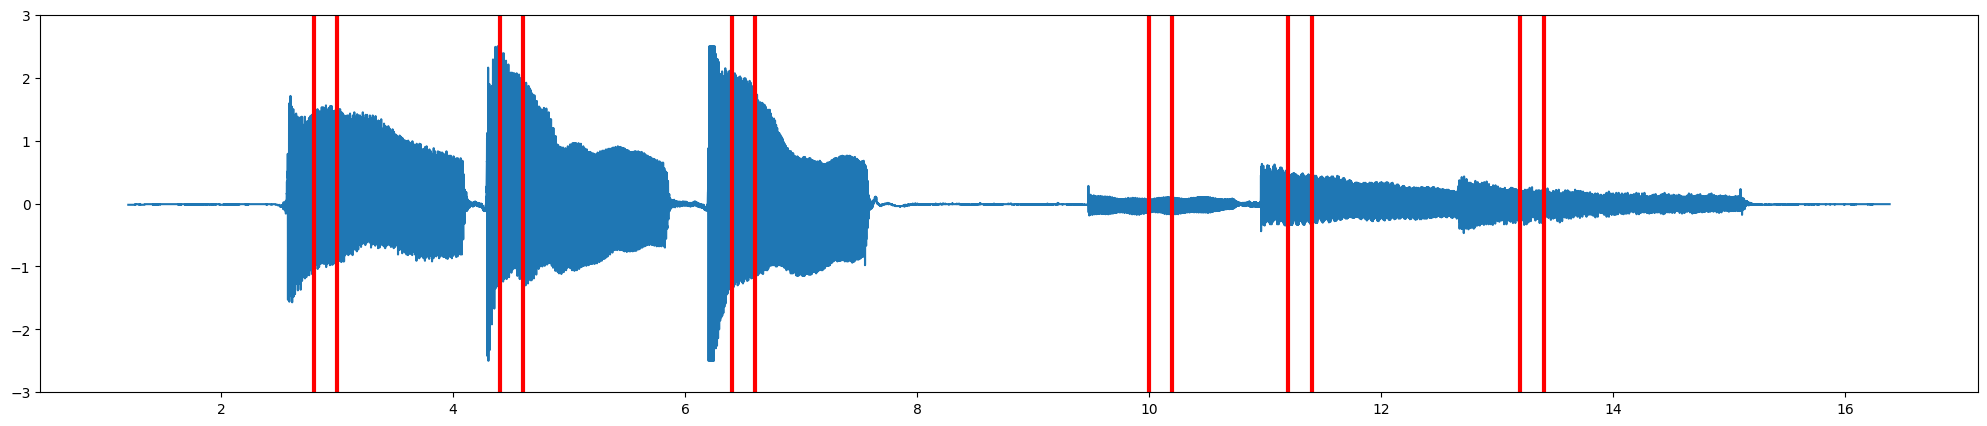

In [3]:
fig = plt.figure(figsize=(25, 5), dpi=100)
plt.ylim(-3,3)
plt.plot(X, Y)

intervals = [4000, 8000, 13000, 22000, 25000, 30000]
expected = [82, 98, 110, 330, 247, 196]

for istart in intervals:
    gt.plotInterval(X, istart, istart+sample_length)

plt.show()

## Slicing

In [4]:
Slices = {'X': list(), 'Y': list()}
Slices['X'] = [gt.slice(X, istart, istart+sample_length) for istart in intervals]
Slices['Y'] = [gt.slice(Y, istart, istart+sample_length) for istart in intervals]

## FFT

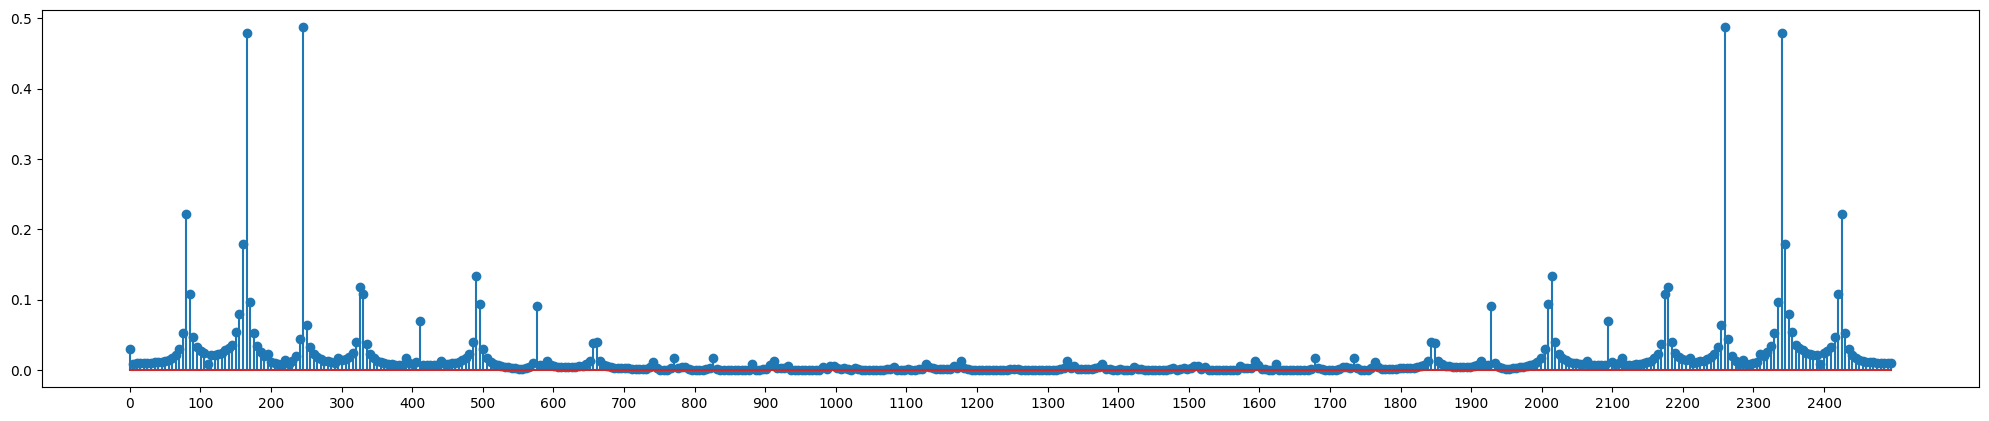

Top 10:  75.0 80.0 155.0 160.0 165.0 240.0 320.0 325.0 485.0 490.0
Expected 82 





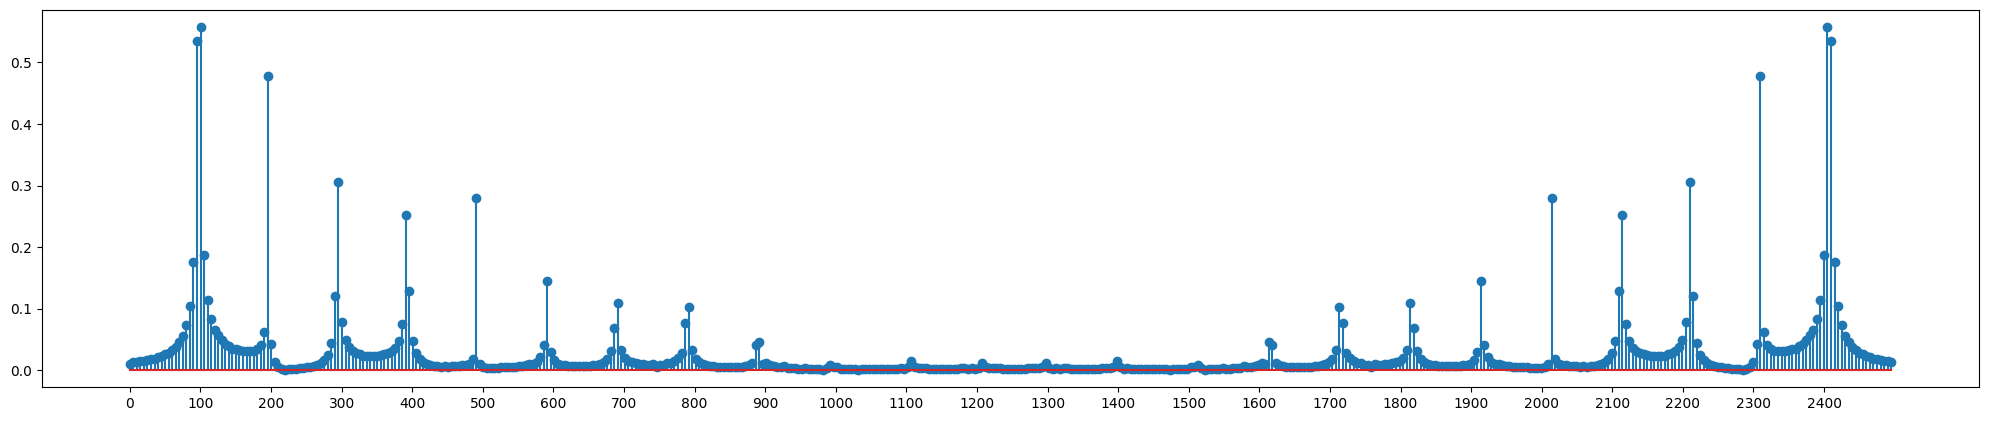

Top 10:  85.0 90.0 95.0 100.0 190.0 290.0 385.0 390.0 485.0 585.0
Expected 98 





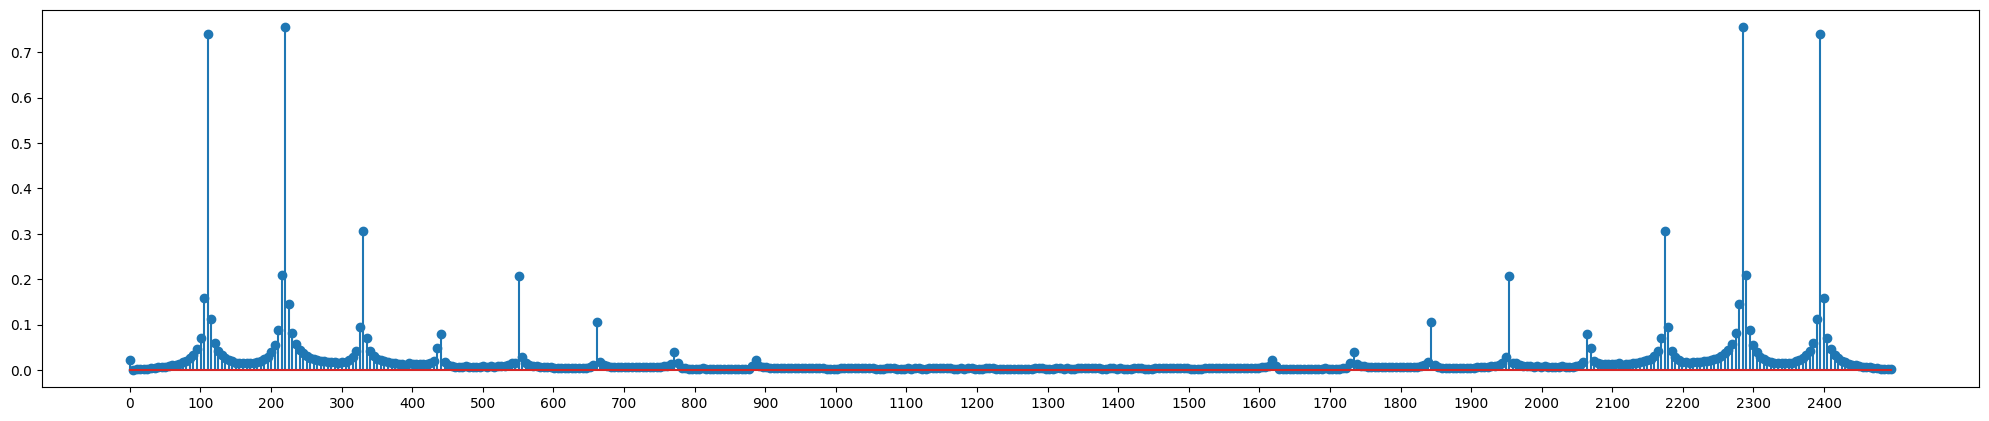

Top 10:  100.0 105.0 110.0 210.0 215.0 220.0 320.0 325.0 545.0 655.0
Expected 110 





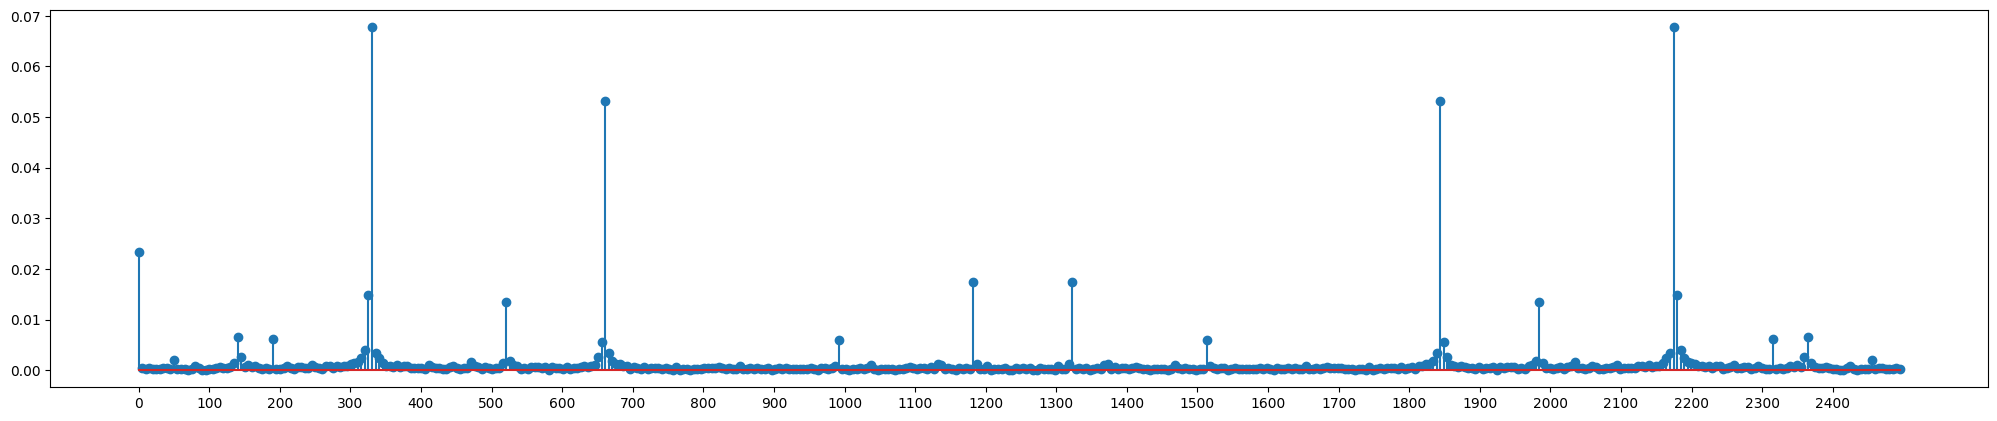

Top 10:  135.0 185.0 315.0 320.0 325.0 515.0 650.0 655.0 985.0 1175.0
Expected 330 





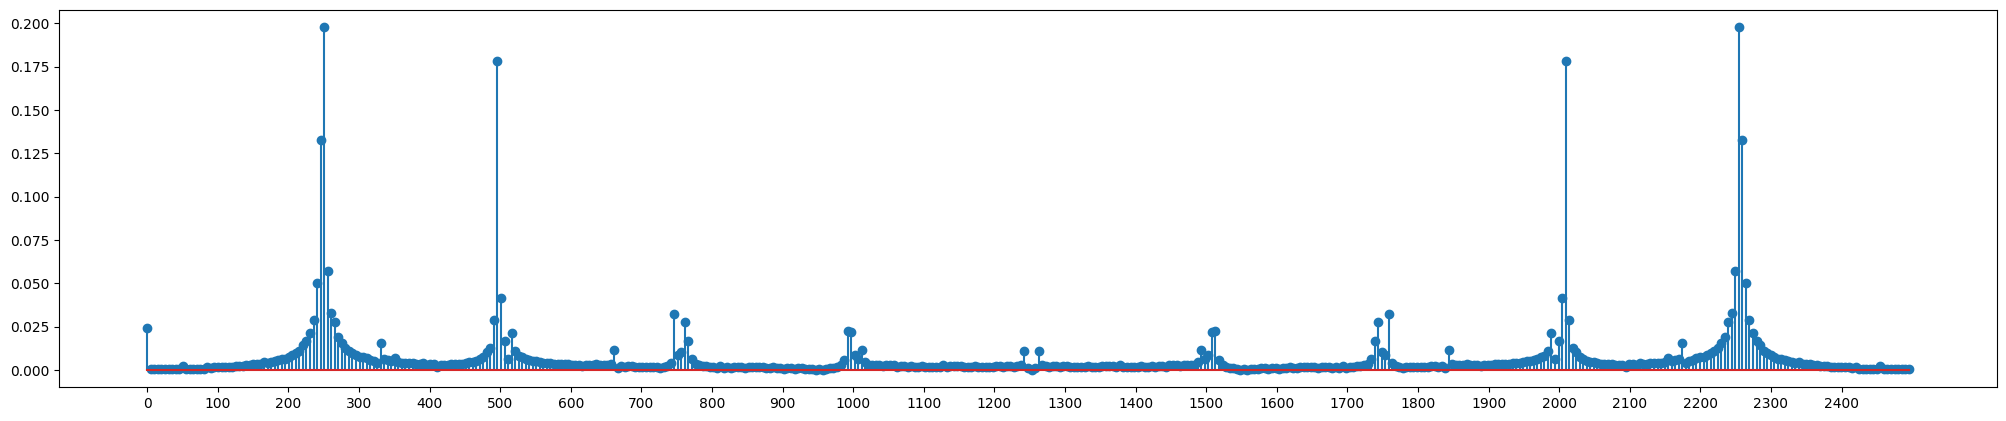

Top 10:  230.0 235.0 240.0 245.0 250.0 255.0 485.0 490.0 495.0 740.0
Expected 247 





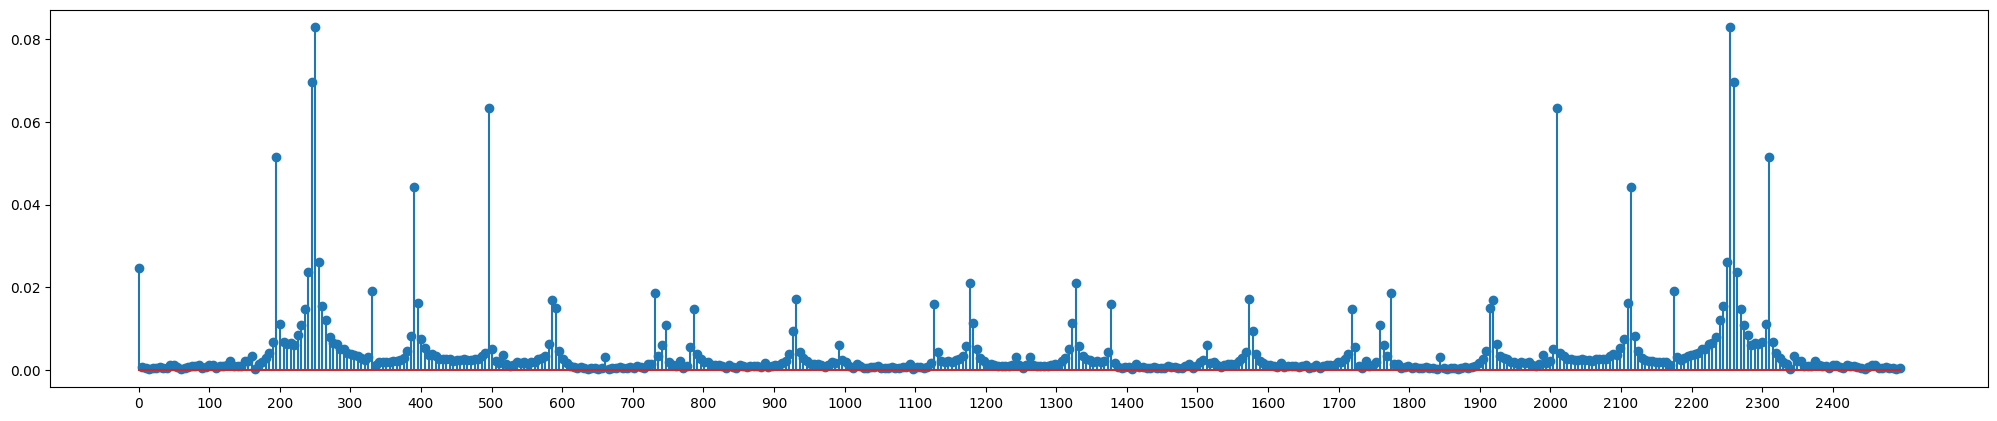

Top 10:  190.0 235.0 240.0 245.0 250.0 325.0 385.0 490.0 725.0 1170.0
Expected 196 





In [5]:
for i, ySlice in enumerate(Slices['Y']):
    gt.plotStem(ySlice, expected=expected[i])

## TODO's

- filtry - odszumianie
- porządna metoda klasyfikacji dźwięków

## Archival

In [12]:
def plot_stem(y,intrv=(0,len(y)),sr=2500):
    y = y[intrv[0]:intrv[1]]
    c = abs(np.fft.fft(y))
    n = len(y)
    #fr = abs(np.fft.fftfreq(len(y)))
    # print(f"samples:{n}")
    # c = c/n * 2
    freqs = np.linspace(0,sr,n)
    #freqs = np.array(range(0,n))
    #freqs = np.array(range(0,n))/4 # 0/4 1/4 2/4 ...

    fig = plt.figure(figsize=(25, 5), dpi=100)
    plt.stem(freqs, c)
    # plt.xticks(freqs[:20])
    i = np.argmax(c[:-n//2]) 
    print(max(c))
    print(i)
    #print(max(y))
    print(f"F:{i/n * sr}")
    print(freqs[i])
    #print(c)
    #print(freqs)
    

In [13]:
def plot_stem3(y, intrv=(0,len(y)), sr=2500, expected=82):
    c = abs(np.fft.fft(y))
    n = len(y)
    c = c/n * 2
    freqs = np.linspace(0,sr,n)
    #freqs = np.array(range(0,sr))/n*sr
    #freqs = np.array(range(0,n))/4 # 0/4 1/4 2/4 ...

    fig = plt.figure(figsize=(25, 5), dpi=100)
    plt.stem(freqs[intrv[0]:intrv[1]], c[intrv[0]:intrv[1]])
    plt.xticks(np.arange(0,2500,100))
    plt.show()
    
    ind = np.argpartition(c[1:-n//2], -10)[-10:]
    print(*sorted([round(indx/n * sr, 2) for indx in ind]))
    print(expected,'\n\n\n')
    # i = np.argmax(c[:-n//2]) 
    # print(f"F:{i/n * sr} i:{i}\n\n\n")
    # print(freqs[i], "\n\n\n\n")
    # TODO filtry - szumy


In [15]:
def plot_stem2(x):
    c = np.fft.fft(x)
    n = len(c)
    fr = np.array(range(0,n))/4 # 0/4 1/4 2/4 ...
    condition = (fr < 600)# & (fr > 100)
    yy = np.abs(c[condition])
    xx = fr[condition]

    a = np.argmax(yy)
    f = xx[a]
    plt.plot(xx,yy)
    plt.axvline(x=f,color='r')
    plt.show()
    print(f"{f} Hz\n\n\n\n")

#plot_stem2(yslice)